In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

'''
NON linear BVP:
     - div( mu(u) * grad(u) ) = f  in domain
                                          u = g  on bdry dirichlet
                         - mu(u) nabla(u).n = c (u^q -u_ref^q) on the 'radiative' bdry
                         - mu(u) nabla(u).n = 0 elsewhere

The diffusivity mu(u) is given, linear or not. 
The RHS (f, u_f) are given.
'''

"\nNON linear BVP:\n     - div( mu(u) * grad(u) ) = f  in domain\n                                          u = g  on bdry dirichlet\n                         - mu(u) nabla(u).n = c (u^q -u_ref^q) on the 'radiative' bdry\n                         - mu(u) nabla(u).n = 0 elsewhere\n\nThe diffusivity mu(u) is given, linear or not. \nThe RHS (f, u_f) are given.\n"

In [2]:
# imports
from fenics import *
from dolfin import *
from sys import exit
import numpy as np 
import numpy.linalg as npl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from math import *
set_log_active(False)

In [3]:
# parameters
tol_bc = 1e-12 # tolerance to be on the domain boundary
eps_du = 1e-9  # tolerance for the non-linear algorithms
I_max = 100 # max number of iterations of the non-linear algorithms
q_degree = 2 # FE degree
dx = dx(metadata={'quadrature_degree': q_degree})

In [4]:
# Define boundaries (useful for Dirichlet BC in particular)
def u_bdry_x0(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[0], 0, tol_bc)))
def u_bdry_x1(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[0], 1, tol_bc)))
def u_bdry_y0(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[1], 0, tol_bc)))
def u_bdry_y1(x, on_boundary): # Left bdry
    return bool(on_boundary and (near(x[1], 1, tol_bc)))

In [5]:
# Mesh & Functional space
NP = 30; print("\n Number of mesh points NP = %i" %NP)
Delta_x = 1./NP
mesh = UnitSquareMesh(NP,NP) # Simple square mesh
k = 2 ; print("Order of the Lagrange FE k = %i\n" %k)
V = FunctionSpace(mesh, "CG", int(k)) # Lagrange FE, order k


 Number of mesh points NP = 30
Order of the Lagrange FE k = 2



In [6]:
# Create classes for defining parts of the boundaries
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0, tol_bc)
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 1.0, tol_bc)
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0, tol_bc)
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 1.0, tol_bc)

left = Left()
top = Top()
right = Right()
bottom = Bottom()

In [7]:
# Initialize mesh function for boundary domains
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)

ds = ds(subdomain_data = boundaries)
# ds(1) = Gamma_in ; ds(2) = Gamma_wall ; ds(3) = Gamma_out ; ds(4) = Gamma_wall

In [8]:
##########################
# Diffusivity function mu
mu0 = 19e-3 # [units=?] and corresponding to what material ? 
#mu0 = 1.
print("The diffusivity constant mu0 = ",mu0)
m = 5 # power-law exponent (in the case of non-linear law)
def mu(u):
    return mu0 * u**m
def dmu(u):
    return m * mu0 * u**(m-1)

The diffusivity constant mu0 =  0.019


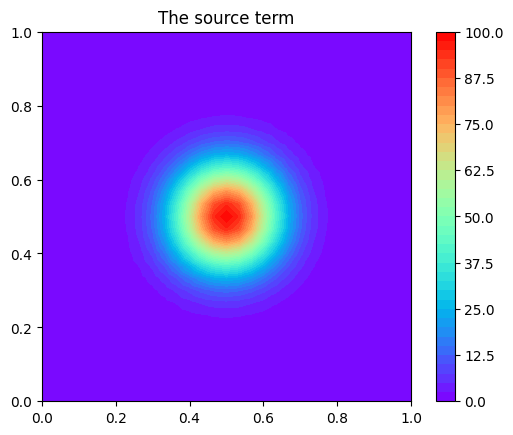

In [9]:
##############
# Source term
fp_exp = Expression(('1e+2*exp(-pow((x[0]-0.5),2)/0.02 - pow((x[1]-0.5),2)/0.02)'), element = V.ufl_element())
#fp_exp = Expression(('0.'), element = V.ufl_element())
fp = interpolate(fp_exp,V)
# Plot
p = plot(fp,title='The source term')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show()

In [10]:
#######
# BCs

# Dirichlet BCs: non homogenous and homogeneous ones
u_diri_val = 3.e2
u_diri_non_hom_exp = Expression('3.e2', element = V.ufl_element()) 
u_diri_non_hom = interpolate(u_diri_non_hom_exp,V)
bc_non_hom = DirichletBC(V, u_diri_non_hom_exp, u_bdry_x0)
#print("The imposed Dirichlet value =", u_diri_non_hom)

u_diri0_exp = Expression('0.',element = V.ufl_element())
bc0 = DirichletBC(V, u_diri0_exp, u_bdry_x0)

# Fluxes BC coefficients
#    Recall: flux BCs are imposed in the weak form
#c = 1. # coeff. value of the flux condition (Robin like condition)
c = 5.65e-8 # Stefan's constant value
q = 4 # the power-law index of the flux law 
u_ref_val = 3.3e2
u_ref_exp = Expression('3.3e2', element = V.ufl_element()) 
u_ref = interpolate(u_ref_exp,V)
print("The non-linear flux coefficients are: (c, q, u_ref) = ", (c,q,u_ref_val))

The non-linear flux coefficients are: (c, q, u_ref) =  (5.65e-08, 4, 330.0)


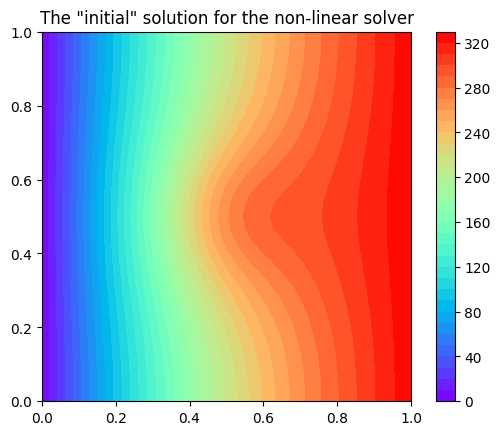

In [11]:
######################################
# Initial solution ("first guess") u0
# u0 = solution of a semi-linearized BVP
######################################
# Case mu constant diffusivity. Non-linear term : non-linear flux
#mu0_diri = mu( interpolate(u_diri_exp_1,V) )

u = TrialFunction(V); v = TestFunction(V)
F0 = mu0 * inner(grad(u),grad(v)) * dx  + c * (u_ref**(q-1) * u - u_ref**q) * v * ds(3)
F0 +=  - fp * v * dx 
a0 = lhs(F0); L0 = rhs(F0)
u_0 = Function(V)
solve(a0 == L0, u_0, bc0)

# Plot
plt.figure()
p = plot(u_0, title='The "initial" solution for the non-linear solver')
p.set_cmap("rainbow"); plt.colorbar(p); plt.show(block=False)


 Non-linear solver by Newton-Raphson algorithm... 
Newton-Raphson loop has finished at iteration  3  with CV criteria  =  4.5556660276025565e-10
A plot is on ...


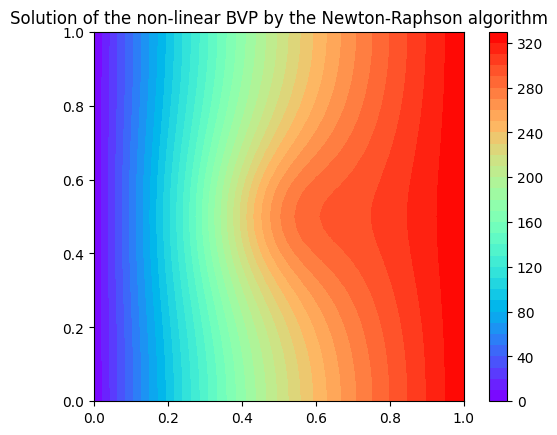

In [12]:
###########################
# Newton-Raphson algorithm 
# Case mu constant diffusivity. Non-linear term : non-linear flux
###########################
print("\n Non-linear solver by Newton-Raphson algorithm... ")
du = TrialFunction(V); dv = TestFunction(V) 
u_n = Function(V); u_n.assign(u_0)

i = 0; error = 1
while i < I_max and error > eps_du :
    i += 1
    # LHS
    da = mu0 * inner(grad(du), grad(v))*dx + q * c * u_n**(q-1) * du * v * ds(3) 
    # RHS
    F = fp*v*dx
    a_n = mu0 * inner(grad(u_n),grad(v))*dx + c * (u_n**q - u_ref**q) * v * ds(3)
    L = F - a_n  
    
    du_n = Function(V)
    solve(da == L, du_n, bc0) # NB: homogeneous BC

    u_n.assign(u_n + du_n)
    # CV criteria  
    u_n_np = u_n.vector().get_local(); du_np = du_n.vector().get_local()
    error = npl.norm(du_np) / npl.norm(u_n_np)
    
    if i % 5 ==0 :
        print("Newton-Raphson iteration %i : CV criteria  = %.13f" %(i,error))

u_newton = u_n
print("Newton-Raphson loop has finished at iteration ",i," with CV criteria  = ", error)


# Plot
plt.figure()
p = plot(u_n, title='Solution of the non-linear BVP by the Newton-Raphson algorithm')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)


 Non-linear solver by the fixed-point algorithm... 
Fixed point iteration 10 with CV criteria = 0.9942864893526
Fixed point iteration 20 with CV criteria = 0.9942864893526
Fixed point iteration 30 with CV criteria = 0.9942864893526
Fixed point iteration 40 with CV criteria = 0.9942864893526
Fixed point iteration 50 with CV criteria = 0.9942864893526
Fixed point iteration 60 with CV criteria = 0.9942864893526
Fixed point iteration 70 with CV criteria = 0.9942864893526
Fixed point iteration 80 with CV criteria = 0.9942864893526
Fixed point iteration 90 with CV criteria = 0.9942864893526
Fixed point iteration 100 with CV criteria = 0.9942864893526
Fixed point loop has finished at iteration  100  with CV criteria =  0.9942864893525653
A plot is on ...


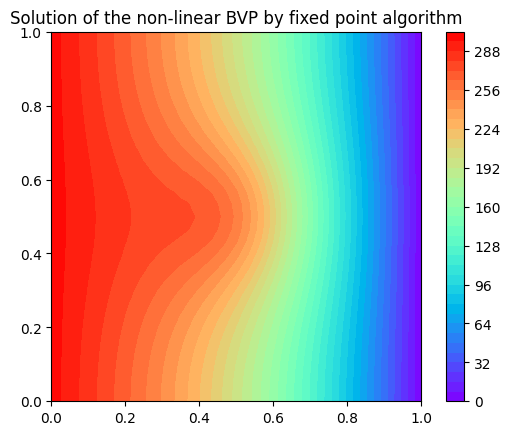

In [13]:
#######################
# Fixed point algorithm
#######################
print("\n Non-linear solver by the fixed-point algorithm... ")
u = TrialFunction(V); dv = TestFunction(V) 
#u_prev = Function(V); u_prev.assign(u_0)
u_prev = u_0

i = 0; error = 1.
while i < I_max and error > eps_du :
    i += 1
    a = mu0 * inner(grad(u), grad(v))*dx + c * u_prev**(q-1) * u * v * ds(3) 
    #a = mu0 * inner(grad(u), grad(v))*dx + c * (u_prev**(q-1) * u  - u_ref**q) * v * ds(3)  
    L = fp*v*dx + c * u_ref**q * v * ds(3) 

    u_new = Function(V)
    solve(a == L, u_new, bc_non_hom)

    # CV criteria  
    u_prev_np = u_prev.vector().get_local(); u_new_np = u_new.vector().get_local()
    error = npl.norm(u_new_np-u_prev_np) / npl.norm(u_prev_np)

    u_prev = u_new # update

    if i % 10 ==0 :
        print("Fixed point iteration %i with CV criteria = %.13f" %(i,error))

u_fixed_pt = u_new
print("Fixed point loop has finished at iteration ",i," with CV criteria = ", error)


# Plot
plt.figure()
p = plot(u_new, title='Solution of the non-linear BVP by fixed point algorithm')
p.set_cmap("rainbow"); plt.colorbar(p)
print("A plot is on ..."); plt.show(block=False)

In [ ]:
#######################
# Comparison of the two solutions
#######################
u_newton_np= u_newton.vector().get_local(); u_fixed_pt_np = u_fixed_pt.vector().get_local()
diff_rel = npl.norm(u_newton_np-u_fixed_pt_np) / npl.norm(u_newton_np)
print("\n Relative difference between the two solutions =", diff_rel)
diff_u = u_newton - u_fixed_pt

# Plot
#plt.figure()
#p = plot(diff_u, title='Difference between the two solutions (Newton-Fixed point)')
#p.set_cmap("rainbow"); plt.colorbar(p)
#print("A plot is on ..."); plt.show()

ans = input("\n Do we close all figs? (y/n) ")
if ans:
    plt.close('all')
print("\n END")


 Relative difference between the two solutions = 0.8172528310284399
